# NBA Game Dashboard Design Outline

# Game Context

- away @ home
- total / spread

# Team Context

- record / L10 record
- injuries
    - players returning from injuries 
    - starting lineups ?
    - highlight key scorers / defenders
- stats allowed (overall + dvp)
- pace(rank) ?

# Player Context

- PTS, REB, AST (+ projection)
    - FPS
    - 3s
        - REB/AST chance data

- hot / cold n-game streak
    - x out of last y
    - season hit %
    - visualize outcomes vs szn/rolling avg
        - visualize attempts/chances
- baseline deviation ?
- matchup
- stats without injured teammate
- home / away splits
- H2H performances

- Similar player recently recorded stats
- Recent scoring/assist performances vs game totals 

In [1]:
home_team = "New Orleans Pelicans"
away_team = "Los Angeles Lakers"
game_total = 235
home_spread = -6
away_spread = 6

print(f"{away_team} @ {home_team}")
print(f"Game total: {game_total}")
print(f"Spreads:\n  Away: {away_spread}\n  Home: {home_spread}")

Los Angeles Lakers @ New Orleans Pelicans
Game total: 235
Spreads:
  Away: 6
  Home: -6


In [2]:
# Connect to database
from sqlalchemy import create_engine
import pandas as pd

DB_USER = "admin"
DB_PASSWORD = "admin"
DB_HOST = "localhost"
DB_PORT = 5433
DB_NAME = "nba_db"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [3]:
query = """
ALTER TABLE boxscores.player_boxscores_traditional_v3
ADD COLUMN IF NOT EXISTS clean_name TEXT;

UPDATE boxscores.player_boxscores_traditional_v3
SET clean_name = regexp_replace(
    lower(unaccent(CONCAT_WS(' ', first_name, family_name))),
    '[^a-z ]',
    '',
    'g'
);

SELECT 
    *,
    AVG(points) OVER (
        PARTITION BY player_id
        ORDER BY game_id
        ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS ppg,
    AVG(points) OVER(
        PARTITION BY player_id
        ORDER BY game_id
        ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING
    ) AS r10_ppg
FROM boxscores.player_boxscores_traditional_v3
WHERE clean_name = 'luka doncic'
"""

pd.read_sql(query, engine).head()

,game_id_api,team_id,team_city,team_name,team_tricode,team_slug,player_id,first_name,family_name,name_initial,...,turnovers,fouls_personal,points,plus_minus_points,game_id,minutes_decimal,player_name,clean_name,ppg,r10_ppg
0,0022400007,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,5,2,31,2.0,0022400007,41.083332,Luka Dončić,luka doncic,NaN,NaN
1,0022400024,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,3,0,26,28.0,0022400024,29.616667,Luka Dončić,luka doncic,31.000000,31.000000
2,0022400056,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,3,4,37,16.0,0022400056,40.466667,Luka Dončić,luka doncic,28.500000,28.500000
3,0022400074,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,4,3,28,6.0,0022400074,36.283333,Luka Dončić,luka doncic,31.333333,31.333333
4,0022400095,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,2,4,40,-12.0,0022400095,39.416668,Luka Dončić,luka doncic,30.500000,30.500000


In [35]:
pbs = pd.read_csv("player_boxscores_2025_26.csv")

# =========================================================
# 0) Sort for correct window behavior
# =========================================================

# Convert game_date to datetime 
pbs["game_date"] = pd.to_datetime(pbs["game_date"])

pbs = (
    pbs
    .sort_values(["personId", "game_date"])
    .reset_index(drop=True)
)

# =========================================================
# 1) Season-to-date average PPG (before current game)
# =========================================================

pbs["szn_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).expanding().mean())
)

# =========================================================
# 2) Rolling 10-game average PPG (before current game)
# =========================================================

pbs["r10_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
)

# =========================================================
# 3) Sanity check (example player)
# =========================================================

luka = pbs[pbs["personId"] == 1629029]

luka[["game_id", "game_date", "points", "szn_avg_ppg", "r10_avg_ppg"]].head(15)


/var/folders/zb/kdjvw_5d73q1b2mg3fkcy8pw0000gn/T/ipykernel_39276/3611845779.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pbs["game_date"] = pd.to_datetime(pbs["game_date"])


,game_id,game_date,points,szn_avg_ppg,r10_avg_ppg
4245,22500002,2025-10-21,43,NaN,NaN
4246,22500019,2025-10-24,49,43.000000,43.000000
4247,22500024,2025-10-31,44,46.000000,46.000000
4248,22500155,2025-11-02,29,45.333333,45.333333
4249,22500179,2025-11-05,35,41.250000,41.250000
4250,22500185,2025-11-08,22,40.000000,40.000000
4251,22500198,2025-11-10,38,37.000000,37.000000
4252,22500222,2025-11-12,19,37.142857,37.142857
4253,22500045,2025-11-14,24,34.875000,34.875000
4254,22500231,2025-11-15,41,33.666667,33.666667


In [10]:
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEASON = "2025-26"
SEASON_TYPE = "Regular Season"
OUTPUT_PATH = Path("league_gamelog_2025_26.csv")

# -----------------------------
# Fetch LeagueGameLog
# -----------------------------
def fetch_league_gamelog():
    print(f"🔍 Fetching LeagueGameLog for {SEASON}...")

    lg = leaguegamelog.LeagueGameLog(
        season=SEASON,
        season_type_all_star=SEASON_TYPE,
        timeout=60
    )

    df = lg.get_data_frames()[0]
    print(f"📊 Rows fetched: {len(df)}")

    return df


# -----------------------------
# Load existing CSV (if any)
# -----------------------------
def load_existing_csv(path):
    if path.exists():
        df_existing = pd.read_csv(path)
        print(f"📁 Existing CSV found: {len(df_existing)} rows")
        return df_existing
    else:
        print("📁 No existing CSV found — creating new file")
        return pd.DataFrame()


# -----------------------------
# Append new rows safely
# -----------------------------
def append_new_rows(df_new, df_existing):
    if df_existing.empty:
        return df_new

    key_cols = ["GAME_ID", "TEAM_ID"]

    existing_keys = set(
        zip(df_existing["GAME_ID"], df_existing["TEAM_ID"])
    )

    mask = [
        (gid, tid) not in existing_keys
        for gid, tid in zip(df_new["GAME_ID"], df_new["TEAM_ID"])
    ]

    df_filtered = df_new[mask]

    print(f"➕ New rows to append: {len(df_filtered)}")

    return pd.concat([df_existing, df_filtered], ignore_index=True)


# -----------------------------
# Main
# -----------------------------
def main():
    df_new = fetch_league_gamelog()
    df_existing = load_existing_csv(OUTPUT_PATH)

    df_final = append_new_rows(df_new, df_existing)

    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(OUTPUT_PATH, index=False)

    print(f"✅ CSV saved → {OUTPUT_PATH}")
    print(f"📦 Total rows in file: {len(df_final)}")


if __name__ == "__main__":
    main()


🔍 Fetching LeagueGameLog for 2025-26...
📊 Rows fetched: 1070
📁 No existing CSV found — creating new file
✅ CSV saved → league_gamelog_2025_26.csv
📦 Total rows in file: 1070


In [13]:
tbs = pd.read_csv("league_gamelog_2025_26.csv")
tbs.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [24]:
import pandas as pd

# =========================================================
# 0) Clean slate: drop existing derived columns if present
# =========================================================

cols_to_drop = [
    "pts_allowed",
    "opp_avg_pts_allowed",
    "opp_r10_pts_allowed",
]

tbs = tbs.drop(columns=[c for c in cols_to_drop if c in tbs.columns])

# =========================================================
# 1) Sort once for deterministic behavior
# =========================================================

tbs = (
    tbs
    .sort_values(["TEAM_ABBREVIATION", "GAME_DATE", "GAME_ID"])
    .reset_index(drop=True)
)

# =========================================================
# 2) Build opponent lookup (PTS → pts_allowed)
# =========================================================

opp = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION", "PTS"]]
    .rename(columns={
        "TEAM_ABBREVIATION": "OPP_TEAM",
        "PTS": "pts_allowed"
    })
)

# =========================================================
# 3) Merge + keep opponent row only
# =========================================================

merged = tbs.merge(
    opp,
    on="GAME_ID",
    how="left",
    validate="many_to_many",
    suffixes=("", "_opp")  # safe now
)

merged = merged[merged["TEAM_ABBREVIATION"] != merged["OPP_TEAM"]]

tbs = merged.drop(columns="OPP_TEAM")

# =========================================================
# 4) Opponent season-to-date avg pts allowed (before game)
# =========================================================

tbs = (
    tbs
    .sort_values(["TEAM_ABBREVIATION", "GAME_DATE", "GAME_ID"])
    .reset_index(drop=True)
)

tbs["opp_avg_pts_allowed"] = (
    tbs
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .transform(lambda s: s.shift(1).expanding().mean())
)

# =========================================================
# 5) Opponent rolling 10-game avg pts allowed (before game)
# =========================================================

tbs["opp_r10_pts_allowed"] = (
    tbs
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
)

# =========================================================
# 6) Sanity check
# =========================================================

(
    tbs[tbs["TEAM_ABBREVIATION"] == "LAL"]
    [["GAME_ID", "GAME_DATE", "PTS", "pts_allowed", "opp_avg_pts_allowed", "opp_r10_pts_allowed"]]
    .head(15)
)


,GAME_ID,GAME_DATE,PTS,pts_allowed,opp_avg_pts_allowed,opp_r10_pts_allowed
464,22500002,2025-10-21,109,119,NaN,NaN
465,22500019,2025-10-24,128,110,119.000000,119.000000
466,22500113,2025-10-26,127,120,114.500000,114.500000
467,22500122,2025-10-27,108,122,116.333333,116.333333
468,22500136,2025-10-29,116,115,117.750000,117.750000
469,22500024,2025-10-31,117,112,117.200000,117.200000
470,22500155,2025-11-02,130,120,116.333333,116.333333
471,22500163,2025-11-03,123,115,116.857143,116.857143
472,22500179,2025-11-05,118,116,116.625000,116.625000
473,22500185,2025-11-08,102,122,116.555556,116.555556


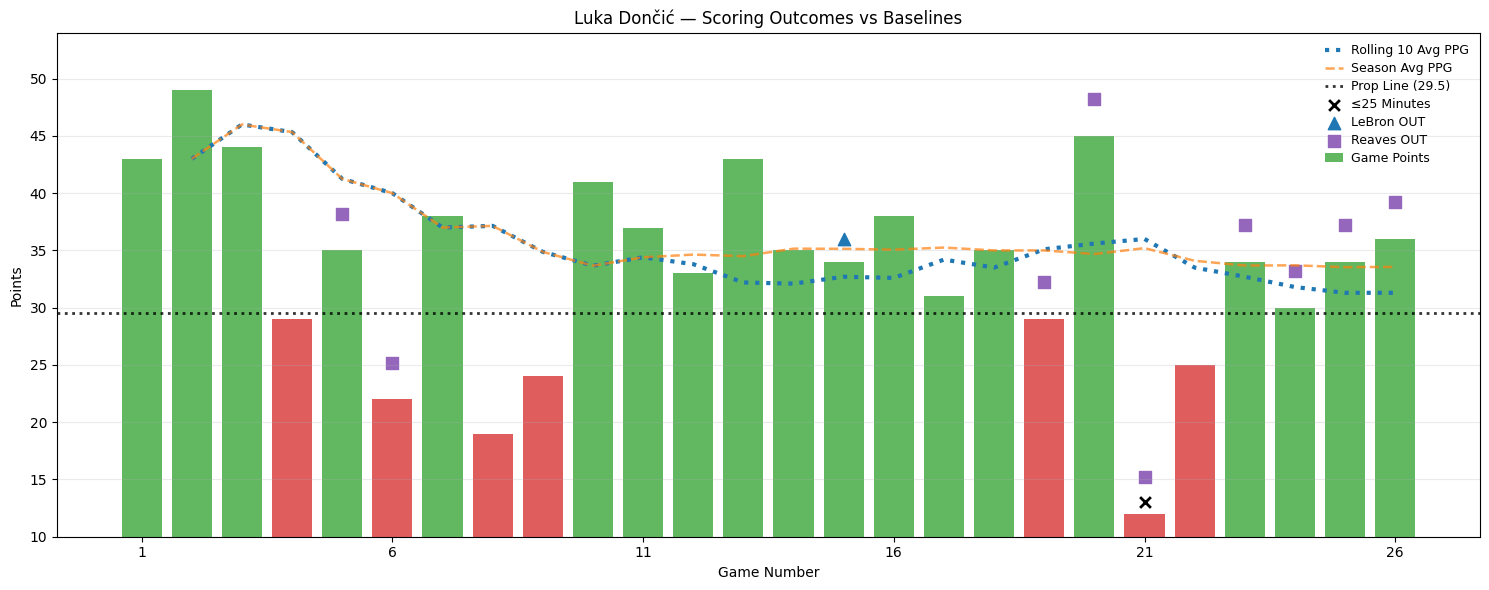

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = (
    luka
    .sort_values(["game_date", "game_id"])
    .reset_index(drop=True)
)

x = np.arange(len(plot_df))

# -----------------------------
# Bar colors based on prop line
# -----------------------------
bar_colors = np.where(
    plot_df["points"] >= 30,
    "tab:green",
    "tab:red"
)

fig, ax = plt.subplots(figsize=(15, 6))

# -----------------------------
# Bars (points)
# -----------------------------
ax.bar(
    x,
    plot_df["points"],
    color=bar_colors,
    alpha=0.75,
    label="Game Points"
)

# -----------------------------
# Rolling 10 avg
# -----------------------------
ax.plot(
    x,
    plot_df["r10_avg_ppg"],
    linestyle=":",
    linewidth=3,
    label="Rolling 10 Avg PPG"
)

# -----------------------------
# Season avg
# -----------------------------
ax.plot(
    x,
    plot_df["szn_avg_ppg"],
    linestyle="--",
    linewidth=1.8,
    alpha=0.7,
    label="Season Avg PPG"
)

# -----------------------------
# Prop line (29.5)
# -----------------------------
ax.axhline(
    29.5,
    linestyle=":",
    linewidth=2,
    color="black",
    alpha=0.8,
    label="Prop Line (29.5)"
)

# -----------------------------
# Low minutes markers (≤25)
# -----------------------------
def minutes_to_float(min_str):
    if pd.isna(min_str):
        return None
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

plot_df["minutes_float"] = plot_df["minutes"].apply(minutes_to_float)
low_min_mask = plot_df["minutes_float"] <= 25

ax.scatter(
    x[low_min_mask],
    plot_df.loc[low_min_mask, "points"] + 1,
    marker="x",
    color="black",
    s=60,
    linewidths=2,
    label="≤25 Minutes"
)

# ----------------------------------
# Identify games where Reaves / LeBron did NOT play
# ----------------------------------

# Normalize names just in case
pbs_names = pbs.copy()
pbs_names["familyName"] = pbs_names["familyName"].str.lower()

# All Luka games
luka_game_ids = set(plot_df["game_id"])

# Games where Reaves played
reaves_games = set(
    pbs_names[
        (pbs_names["familyName"] == "reaves") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

# Games where LeBron played
lebron_games = set(
    pbs_names[
        (pbs_names["familyName"] == "james") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

# Boolean masks on plot_df
plot_df["reaves_out"] = ~plot_df["game_id"].isin(reaves_games)
plot_df["lebron_out"] = ~plot_df["game_id"].isin(lebron_games)

# -----------------------------
# Axis formatting
# -----------------------------
ax.set_ylim(10, plot_df["points"].max() + 5)
ax.set_ylabel("Points")
ax.set_xlabel("Game Number")
ax.set_title("Luka Dončić — Scoring Outcomes vs Baselines")

# -----------------------------
# Teammate-specific absence markers
# -----------------------------

# LeBron OUT → blue triangle
ax.scatter(
    x[plot_df["lebron_out"]],
    plot_df.loc[plot_df["lebron_out"], "points"] + 2.0,
    marker="^",
    color="tab:blue",
    s=80,
    label="LeBron OUT"
)

# Reaves OUT → purple square
ax.scatter(
    x[plot_df["reaves_out"]],
    plot_df.loc[plot_df["reaves_out"], "points"] + 3.2,
    marker="s",
    color="tab:purple",
    s=70,
    label="Reaves OUT"
)

# Label every 5th game
ax.set_xticks(x[::5])
ax.set_xticklabels(x[::5] + 1)

ax.grid(axis="y", alpha=0.25)
ax.legend(
    fontsize=9,
    frameon=False,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()


In [69]:
import pandas as pd

# =========================================================
# 0) Prep + type safety
# =========================================================

tbs_def = tbs.copy()

tbs_def["GAME_DATE"] = pd.to_datetime(tbs_def["GAME_DATE"])

# Defensive stats become available the day AFTER the game
tbs_def["as_of_date"] = tbs_def["GAME_DATE"] + pd.Timedelta(days=1)

# Keep only what we need
tbs_def = tbs_def[
    ["TEAM_ABBREVIATION", "as_of_date", "pts_allowed"]
].sort_values(["as_of_date", "TEAM_ABBREVIATION"])

# =========================================================
# 1) Build cumulative defensive stats per team
# =========================================================

tbs_def["games_played"] = (
    tbs_def
    .groupby("TEAM_ABBREVIATION")
    .cumcount()
    + 1
)

tbs_def["cum_pts_allowed"] = (
    tbs_def
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .cumsum()
)

tbs_def["avg_pts_allowed"] = (
    tbs_def["cum_pts_allowed"] / tbs_def["games_played"]
)

# =========================================================
# 2) Build DAILY league snapshots
# =========================================================

snapshots = []

all_dates = (
    tbs_def["as_of_date"]
    .sort_values()
    .unique()
)

for d in all_dates:
    # Latest known defensive state per team as of date d
    snap = (
        tbs_def[tbs_def["as_of_date"] <= d]
        .sort_values("as_of_date")
        .groupby("TEAM_ABBREVIATION", as_index=False)
        .last()
    )

    # Only rank once at least 2 teams exist
    if len(snap) < 2:
        continue

    snap = snap.sort_values("avg_pts_allowed")

    snap["def_rank"] = range(1, len(snap) + 1)
    snap["as_of_date"] = d

    snapshots.append(
        snap[
            [
                "as_of_date",
                "TEAM_ABBREVIATION",
                "games_played",
                "avg_pts_allowed",
                "def_rank",
            ]
        ]
    )

team_defense_daily = (
    pd.concat(snapshots)
    .sort_values(["as_of_date", "def_rank"])
    .reset_index(drop=True)
)

team_defense_daily.tail(30)


,as_of_date,TEAM_ABBREVIATION,games_played,avg_pts_allowed,def_rank
2162,2026-01-06,OKC,37,107.621622,1
2163,2026-01-06,BOS,35,110.457143,2
2164,2026-01-06,HOU,33,110.969697,3
2165,2026-01-06,DET,36,112.111111,4
2166,2026-01-06,TOR,37,112.297297,5
2167,2026-01-06,PHX,36,112.805556,6
2168,2026-01-06,GSW,37,113.648649,7
2169,2026-01-06,SAS,35,114.171429,8
2170,2026-01-06,LAC,35,114.200000,9
2171,2026-01-06,BKN,33,114.272727,10


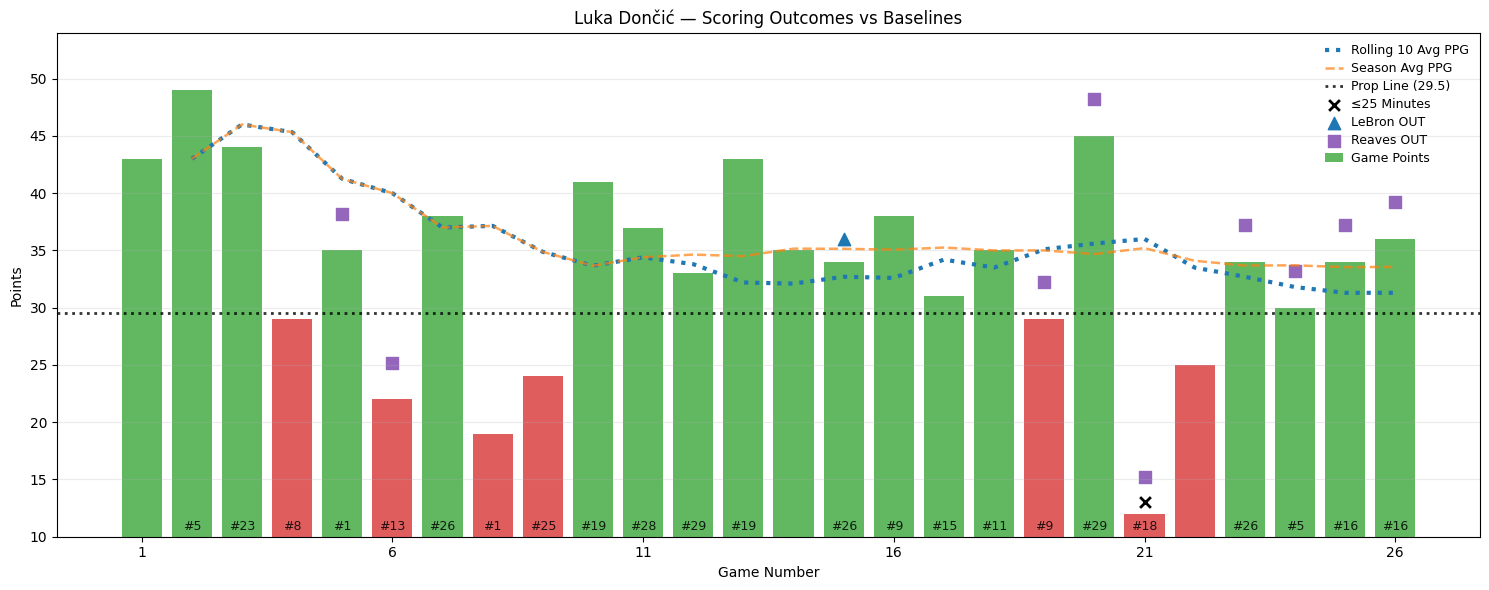

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================================================
# 0) Prepare Luka data
# =========================================================

plot_df = (
    luka
    .sort_values(["game_date", "game_id"])
    .reset_index(drop=True)
)

plot_df["game_date"] = pd.to_datetime(plot_df["game_date"])

x = np.arange(len(plot_df))

# =========================================================
# 1) Attach opponent defensive rank (NO leakage)
# =========================================================

# Luka opponent per game (from team box scores)
luka_games = (
    plot_df[["game_id", "game_date", "teamTricode"]]
    .rename(columns={"teamTricode": "LUKA_TEAM"})
)

# Find opponent team per game using tbs
opp_map = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION"]]
    .rename(columns={"GAME_ID": "game_id", "TEAM_ABBREVIATION": "OPP_TEAM"})
)

luka_games = (
    luka_games
    .merge(opp_map, on="game_id", how="left")
    .query("OPP_TEAM != LUKA_TEAM")
    .drop(columns="LUKA_TEAM")
)

# Join to defense table using as_of_date = game_date
plot_df = (
    plot_df
    .merge(
        luka_games[["game_id", "OPP_TEAM"]],
        on="game_id",
        how="left"
    )
    .merge(
        team_defense_daily,
        left_on=["OPP_TEAM", "game_date"],
        right_on=["TEAM_ABBREVIATION", "as_of_date"],
        how="left"
    )
)

# Defensive rank to plot
plot_df["opp_def_rank"] = plot_df["def_rank"]

# =========================================================
# 2) Bar colors (prop logic)
# =========================================================

bar_colors = np.where(
    plot_df["points"] >= 30,
    "tab:green",
    "tab:red"
)

# =========================================================
# 3) Plot
# =========================================================

fig, ax = plt.subplots(figsize=(15, 6))

# Bars
ax.bar(
    x,
    plot_df["points"],
    color=bar_colors,
    alpha=0.75,
    label="Game Points"
)

# Rolling 10 avg
ax.plot(
    x,
    plot_df["r10_avg_ppg"],
    linestyle=":",
    linewidth=3,
    label="Rolling 10 Avg PPG"
)

# Season avg
ax.plot(
    x,
    plot_df["szn_avg_ppg"],
    linestyle="--",
    linewidth=1.8,
    alpha=0.7,
    label="Season Avg PPG"
)

# Prop line
ax.axhline(
    29.5,
    linestyle=":",
    linewidth=2,
    color="black",
    alpha=0.8,
    label="Prop Line (29.5)"
)

# =========================================================
# 4) Low minutes markers (≤25)
# =========================================================

def minutes_to_float(min_str):
    if pd.isna(min_str):
        return None
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

plot_df["minutes_float"] = plot_df["minutes"].apply(minutes_to_float)
low_min_mask = plot_df["minutes_float"] <= 25

ax.scatter(
    x[low_min_mask],
    plot_df.loc[low_min_mask, "points"] + 1,
    marker="x",
    color="black",
    s=60,
    linewidths=2,
    label="≤25 Minutes"
)

# =========================================================
# 5) Teammate absence markers
# =========================================================

pbs_names = pbs.copy()
pbs_names["familyName"] = pbs_names["familyName"].str.lower()

luka_game_ids = set(plot_df["game_id"])

reaves_games = set(
    pbs_names[
        (pbs_names["familyName"] == "reaves") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

lebron_games = set(
    pbs_names[
        (pbs_names["familyName"] == "james") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

plot_df["reaves_out"] = ~plot_df["game_id"].isin(reaves_games)
plot_df["lebron_out"] = ~plot_df["game_id"].isin(lebron_games)

ax.scatter(
    x[plot_df["lebron_out"]],
    plot_df.loc[plot_df["lebron_out"], "points"] + 2.0,
    marker="^",
    color="tab:blue",
    s=80,
    label="LeBron OUT"
)

ax.scatter(
    x[plot_df["reaves_out"]],
    plot_df.loc[plot_df["reaves_out"], "points"] + 3.2,
    marker="s",
    color="tab:purple",
    s=70,
    label="Reaves OUT"
)

# =========================================================
# 6) Defensive rank labels under bars
# =========================================================

for i, rank in enumerate(plot_df["opp_def_rank"]):
    if pd.notna(rank):
        ax.text(
            i,
            10.3,
            f"#{int(rank)}",
            ha="center",
            va="bottom",
            fontsize=9,
            alpha=0.85
        )

# =========================================================
# 7) Axis formatting
# =========================================================

ax.set_ylim(10, plot_df["points"].max() + 5)
ax.set_ylabel("Points")
ax.set_xlabel("Game Number")
ax.set_title("Luka Dončić — Scoring Outcomes vs Baselines")

ax.set_xticks(x[::5])
ax.set_xticklabels(x[::5] + 1)

ax.grid(axis="y", alpha=0.25)
ax.legend(
    fontsize=9,
    frameon=False,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()


In [75]:
import pandas as pd

# -----------------------------
# Identify games with missing ranks
# -----------------------------
missing = plot_df[plot_df["opp_def_rank"].isna()].copy()
# Derive game_number from order (1-based)
missing["game_number"] = missing.index + 1

print("Games with missing opponent defensive rank:")
display(
    missing[["game_number", "game_date", "OPP_TEAM"]]
)

# -----------------------------
# Inspect each missing case
# -----------------------------
debug_rows = []

for _, row in missing.iterrows():
    game_num = row["game_number"]
    game_date = row["game_date"]
    opp = row["OPP_TEAM"]

    # All defensive-rank snapshots available BEFORE this game
    prior_ranks = (
        team_defense_daily[
            (team_defense_daily["TEAM_ABBREVIATION"] == opp) &
            (team_defense_daily["as_of_date"] < game_date)
        ]
        .sort_values("as_of_date")
    )

    debug_rows.append({
        "game_number": game_num,
        "game_date": game_date.date(),
        "opponent": opp,
        "prior_rows_exist": len(prior_ranks) > 0,
        "most_recent_as_of": (
            prior_ranks["as_of_date"].iloc[-1].date()
            if len(prior_ranks) > 0 else None
        ),
        "most_recent_rank": (
            prior_ranks["def_rank"].iloc[-1]
            if len(prior_ranks) > 0 else None
        )
    })

debug_df = pd.DataFrame(debug_rows)

print("\nWhy ranks are missing:")
display(debug_df)


Games with missing opponent defensive rank:


,game_number,game_date,OPP_TEAM
0,1,2025-10-21,GSW
13,14,2025-11-28,DAL
21,22,2025-12-25,HOU



Why ranks are missing:


,game_number,game_date,opponent,prior_rows_exist,most_recent_as_of,most_recent_rank
0,1,2025-10-21,GSW,False,None,NaN
1,14,2025-11-28,DAL,True,2025-11-27,16.0
2,22,2025-12-25,HOU,True,2025-12-24,6.0


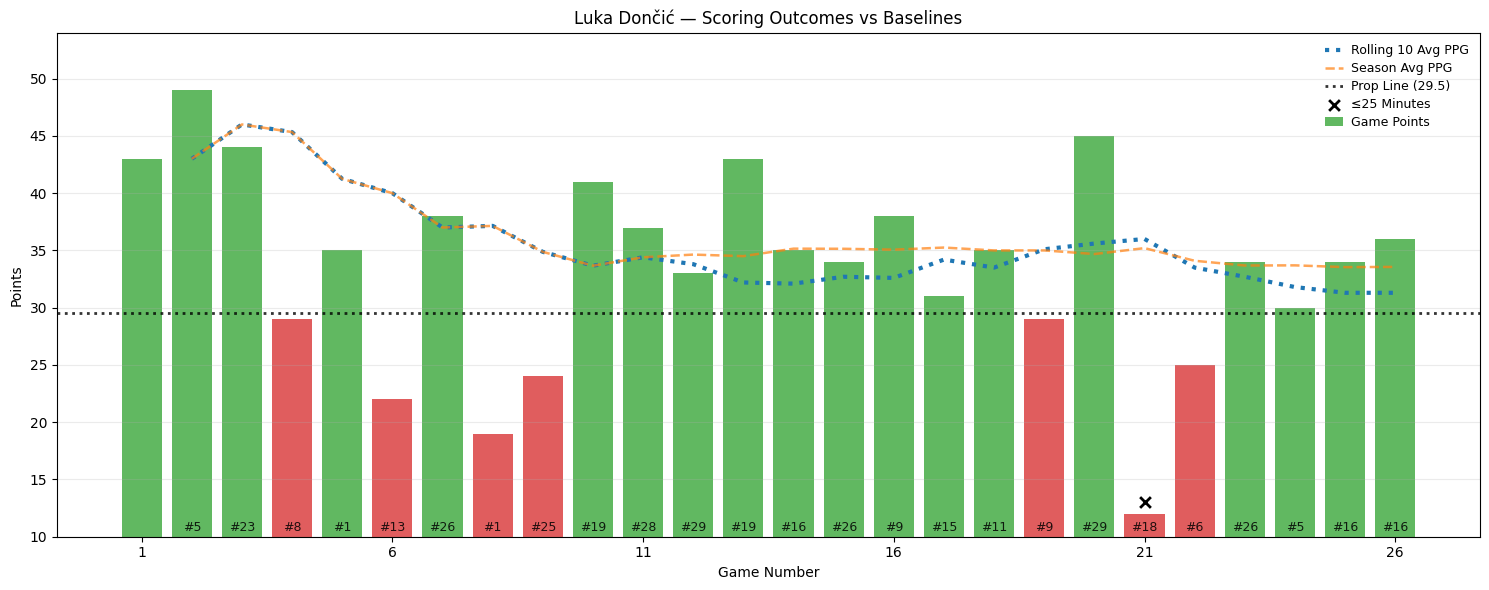

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 1) Prepare Luka plotting dataframe
# =========================================================

plot_df = (
    luka
    .sort_values(["game_date", "game_id"])
    .reset_index(drop=True)
)

plot_df["game_number"] = np.arange(1, len(plot_df) + 1)
x = np.arange(len(plot_df))

plot_df["game_date_dt"] = pd.to_datetime(plot_df["game_date"])

# =========================================================
# 2) Build opponent lookup from TEAM box scores
# =========================================================

opp_lookup = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION"]]
    .rename(columns={
        "GAME_ID": "game_id",
        "TEAM_ABBREVIATION": "team"
    })
)

opp_lookup = (
    opp_lookup
    .merge(
        opp_lookup,
        on="game_id",
        suffixes=("", "_opp")
    )
    .query("team != team_opp")
    [["game_id", "team", "team_opp"]]
    .drop_duplicates()
    .rename(columns={"team_opp": "OPP_TEAM"})
)

# Luka team = LAL
plot_df = plot_df.merge(
    opp_lookup[opp_lookup["team"] == "LAL"][["game_id", "OPP_TEAM"]],
    on="game_id",
    how="left",
    validate="one_to_one"
)

# =========================================================
# 3) AS-OF MERGE opponent defensive rank (FIXED)
# =========================================================

team_defense_daily = team_defense_daily.copy()
team_defense_daily["as_of_date"] = pd.to_datetime(team_defense_daily["as_of_date"])

# 🔑 Make join key names match
team_defense_daily = team_defense_daily.rename(
    columns={"TEAM_ABBREVIATION": "OPP_TEAM"}
)

plot_df = plot_df.sort_values("game_date_dt")
team_defense_daily = team_defense_daily.sort_values("as_of_date")

plot_df = pd.merge_asof(
    plot_df,
    team_defense_daily,
    left_on="game_date_dt",
    right_on="as_of_date",
    by="OPP_TEAM",
    direction="backward"
)

plot_df = plot_df.rename(columns={"def_rank": "opp_def_rank"})

# =========================================================
# 4) Bar colors
# =========================================================

bar_colors = np.where(
    plot_df["points"] >= 30,
    "tab:green",
    "tab:red"
)

# =========================================================
# 5) Plot
# =========================================================

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(
    x,
    plot_df["points"],
    color=bar_colors,
    alpha=0.75,
    label="Game Points"
)

ax.plot(
    x,
    plot_df["r10_avg_ppg"],
    linestyle=":",
    linewidth=3,
    label="Rolling 10 Avg PPG"
)

ax.plot(
    x,
    plot_df["szn_avg_ppg"],
    linestyle="--",
    linewidth=1.8,
    alpha=0.7,
    label="Season Avg PPG"
)

ax.axhline(
    29.5,
    linestyle=":",
    linewidth=2,
    color="black",
    alpha=0.8,
    label="Prop Line (29.5)"
)

# =========================================================
# 6) Low minutes marker
# =========================================================

def minutes_to_float(min_str):
    if pd.isna(min_str):
        return np.nan
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

plot_df["minutes_float"] = plot_df["minutes"].apply(minutes_to_float)
low_min_mask = plot_df["minutes_float"] <= 25

ax.scatter(
    x[low_min_mask],
    plot_df.loc[low_min_mask, "points"] + 1,
    marker="x",
    color="black",
    s=60,
    linewidths=2,
    label="≤25 Minutes"
)

# =========================================================
# 7) Opponent defensive rank labels (bottom)
# =========================================================

for i, rank in enumerate(plot_df["opp_def_rank"]):
    if not pd.isna(rank):
        ax.text(
            i,
            10.2,
            f"#{int(rank)}",
            ha="center",
            va="bottom",
            fontsize=9,
            alpha=0.85
        )

# =========================================================
# 8) Formatting
# =========================================================

ax.set_ylim(10, plot_df["points"].max() + 5)
ax.set_ylabel("Points")
ax.set_xlabel("Game Number")
ax.set_title("Luka Dončić — Scoring Outcomes vs Baselines")

ax.set_xticks(x[::5])
ax.set_xticklabels(plot_df["game_number"][::5])

ax.grid(axis="y", alpha=0.25)
ax.legend(
    fontsize=9,
    frameon=False,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()


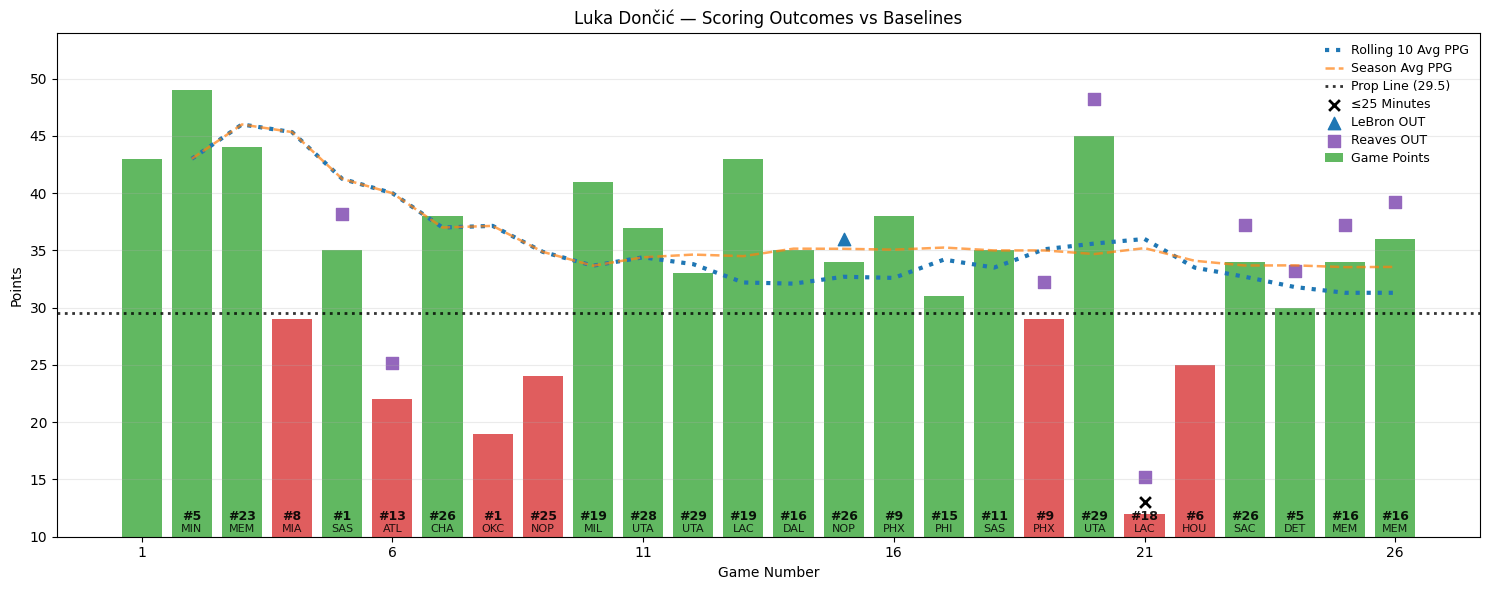

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 1) Prepare Luka plotting dataframe
# =========================================================

plot_df = (
    luka
    .sort_values(["game_date", "game_id"])
    .reset_index(drop=True)
)

plot_df["game_number"] = np.arange(1, len(plot_df) + 1)
x = np.arange(len(plot_df))

plot_df["game_date_dt"] = pd.to_datetime(plot_df["game_date"])

# =========================================================
# 2) Build opponent lookup from TEAM box scores
# =========================================================

opp_lookup = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION"]]
    .rename(columns={
        "GAME_ID": "game_id",
        "TEAM_ABBREVIATION": "team"
    })
)

opp_lookup = (
    opp_lookup
    .merge(
        opp_lookup,
        on="game_id",
        suffixes=("", "_opp")
    )
    .query("team != team_opp")
    [["game_id", "team", "team_opp"]]
    .drop_duplicates()
    .rename(columns={"team_opp": "OPP_TEAM"})
)

# Luka team = LAL
plot_df = plot_df.merge(
    opp_lookup[opp_lookup["team"] == "LAL"][["game_id", "OPP_TEAM"]],
    on="game_id",
    how="left",
    validate="one_to_one"
)

# =========================================================
# 3) AS-OF MERGE opponent defensive rank
# =========================================================

team_defense_daily = team_defense_daily.copy()
team_defense_daily["as_of_date"] = pd.to_datetime(team_defense_daily["as_of_date"])

team_defense_daily = team_defense_daily.rename(
    columns={"TEAM_ABBREVIATION": "OPP_TEAM"}
)

plot_df = plot_df.sort_values("game_date_dt")
team_defense_daily = team_defense_daily.sort_values("as_of_date")

plot_df = pd.merge_asof(
    plot_df,
    team_defense_daily,
    left_on="game_date_dt",
    right_on="as_of_date",
    by="OPP_TEAM",
    direction="backward"
)

plot_df = plot_df.rename(columns={"def_rank": "opp_def_rank"})

# =========================================================
# 4) Bar colors (prop logic)
# =========================================================

bar_colors = np.where(
    plot_df["points"] >= 30,
    "tab:green",
    "tab:red"
)

# =========================================================
# 5) Plot
# =========================================================

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(
    x,
    plot_df["points"],
    color=bar_colors,
    alpha=0.75,
    label="Game Points"
)

ax.plot(
    x,
    plot_df["r10_avg_ppg"],
    linestyle=":",
    linewidth=3,
    label="Rolling 10 Avg PPG"
)

ax.plot(
    x,
    plot_df["szn_avg_ppg"],
    linestyle="--",
    linewidth=1.8,
    alpha=0.7,
    label="Season Avg PPG"
)

ax.axhline(
    29.5,
    linestyle=":",
    linewidth=2,
    color="black",
    alpha=0.8,
    label="Prop Line (29.5)"
)

# =========================================================
# 6) Low minutes marker (≤25)
# =========================================================

def minutes_to_float(min_str):
    if pd.isna(min_str):
        return np.nan
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

plot_df["minutes_float"] = plot_df["minutes"].apply(minutes_to_float)
low_min_mask = plot_df["minutes_float"] <= 25

ax.scatter(
    x[low_min_mask],
    plot_df.loc[low_min_mask, "points"] + 1,
    marker="x",
    color="black",
    s=60,
    linewidths=2,
    label="≤25 Minutes"
)

# =========================================================
# 7) Teammate absence markers
# =========================================================

pbs_names = pbs.copy()
pbs_names["familyName"] = pbs_names["familyName"].str.lower()

luka_game_ids = set(plot_df["game_id"])

reaves_games = set(
    pbs_names[
        (pbs_names["familyName"] == "reaves") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

lebron_games = set(
    pbs_names[
        (pbs_names["familyName"] == "james") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

plot_df["reaves_out"] = ~plot_df["game_id"].isin(reaves_games)
plot_df["lebron_out"] = ~plot_df["game_id"].isin(lebron_games)

ax.scatter(
    x[plot_df["lebron_out"]],
    plot_df.loc[plot_df["lebron_out"], "points"] + 2.0,
    marker="^",
    color="tab:blue",
    s=80,
    label="LeBron OUT"
)

ax.scatter(
    x[plot_df["reaves_out"]],
    plot_df.loc[plot_df["reaves_out"], "points"] + 3.2,
    marker="s",
    color="tab:purple",
    s=70,
    label="Reaves OUT"
)

# =========================================================
# 8) Opponent team + defensive rank labels (BOTTOM)
# =========================================================

for i, row in plot_df.iterrows():
    if not pd.isna(row["opp_def_rank"]):
        ax.text(
            i,
            10.2,
            f'{row["OPP_TEAM"]}',
            ha="center",
            va="bottom",
            fontsize=8,
            alpha=0.85
        )
        ax.text(
            i,
            11.2,
            f'#{int(row["opp_def_rank"])}',
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            alpha=0.9
        )

# =========================================================
# 9) Formatting
# =========================================================

ax.set_ylim(10, plot_df["points"].max() + 5)
ax.set_ylabel("Points")
ax.set_xlabel("Game Number")
ax.set_title("Luka Dončić — Scoring Outcomes vs Baselines")

ax.set_xticks(x[::5])
ax.set_xticklabels(plot_df["game_number"][::5])

ax.grid(axis="y", alpha=0.25)
ax.legend(
    fontsize=9,
    frameon=False,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()
